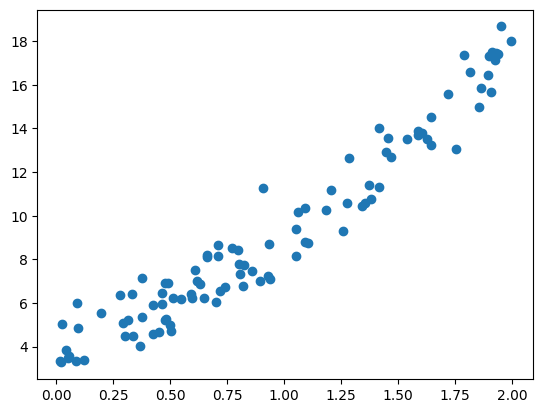

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Ridge, LinearRegression, Lasso, SGDRegressor
from numpy import asarray


# Make data
np.random.seed(67)
n = 100
X = 2 * np.random.rand(n, 1)

y = 4 + 3 * X + 2*X**2 + np.random.randn(n, 1)

# Splitting into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=32)

# Splitting into train and validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=32)

# Plot data
plt.scatter(X,y)

# Hyperparameters
degree = 2 
batch_size = 32
epochs = 1000
decay1 = 0.9
decay2 = 0.999
epsilon = 1e-8
momentum = 0.9
decay_rate = 0.9

# REGRESSION

# Ridge

### plain GD fixed learning rate to tune

The best model having lambda = 0.0001 used eta = 0.01 with validation MSE = 1.0462.
The best model having lambda = 0.001 used eta = 0.01 with validation MSE = 1.0461.
The best model having lambda = 0.01 used eta = 0.01 with validation MSE = 1.0474.
The best model having lambda = 0.1 used eta = 0.01 with validation MSE = 1.1892.
Overall, the best model has lambda = 0.001, eta = 0.01, validation MSE = 1.0461263099561238 and betas = [[3.63016122]
 [2.57147747]
 [2.26778965]].


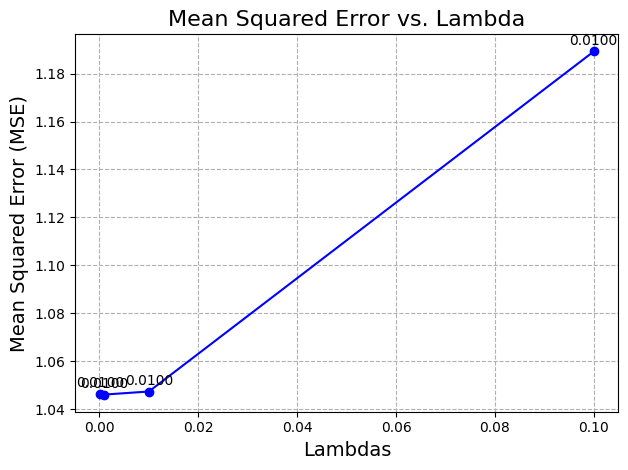

In [2]:
# by hand
def plain_GD(X_train, X_val, y_train, y_val, degree, lmbda, epochs):
    np.random.seed(32)
    best_model = None
    best_eta = None
    min_mse_val = float('inf')
    
    # Generate polynomial features for each degree
    poly = PolynomialFeatures(degree=degree)

    # Transform the original training and validation sets
    X_train_poly = poly.fit_transform(X_train)
    X_val_poly = poly.transform(X_val)
    
    # Compute the Hessian matrix (based on X_train_poly)
    H = (2.0 / len(y_train)) * X_train_poly.T @ X_train_poly + 2 * lmbda * np.eye(X_train_poly.shape[1])
    # Get the eigenvalues
    EigValues, _ = np.linalg.eig(H)
    
    # Learning rates to test
    learning_rates = [0.001, 0.01, 0.1, 1.0 / np.max(EigValues)]

    for eta in learning_rates:
        
        # Initialize beta with the correct size based on the degree
        beta = np.random.randn(X_train_poly.shape[1], 1)
        
        for iter in range(epochs):
            # Gradient of the cost function
            gradient = (2.0 / len(y_train)) * X_train_poly.T @ (X_train_poly @ beta - y_train) + 2 * lmbda * beta

            tolerance = np.full_like(gradient, 0.0001)
            
            if np.all(np.abs(gradient) <= tolerance):
                break
            # Update beta
            beta -= eta * gradient
        
        # TRAIN - Calculate MSE for training data
        y_hat_train = np.dot(X_train_poly, beta)
        mse_train = mean_squared_error(y_train, y_hat_train)
    
        # VALIDATION - Calculate MSE for validation data
        y_hat_val = np.dot(X_val_poly, beta)
        mse_val = mean_squared_error(y_val, y_hat_val)
    
        # Save the best model based on validation MSE
        if mse_val < min_mse_val:
            min_mse_val = mse_val
            best_model = beta
            best_eta = eta

    print(f"The best model having lambda = {lmbda} used eta = {best_eta} with validation MSE = {round(min_mse_val, 4)}.")
    return best_model, min_mse_val, best_eta

lambdas = [0.0001, 0.001, 0.01, 0.1]
all_mse = []
all_eta = []
for lmbda in lambdas:
    coefs, mse, eta = plain_GD(X_train, X_val, y_train, y_val, degree, lmbda, epochs)
    all_mse.append(mse)
    all_eta.append(eta)

print(f"Overall, the best model has lambda = {lambdas[all_mse.index(min(all_mse))]}, eta = {all_eta[all_mse.index(min(all_mse))]}, validation MSE = {min(all_mse)} and betas = {coefs}.")

plt.plot(lambdas, all_mse, marker='o', linestyle='-', color='b')
for i, txt in enumerate(all_eta):
    plt.annotate(f'{txt:.4f}', (lambdas[i], all_mse[i]), textcoords="offset points", xytext=(0,5), ha='center')

plt.xlabel("Lambdas", fontsize=14)
plt.ylabel("Mean Squared Error (MSE)", fontsize=14)
plt.title("Mean Squared Error vs. Lambda", fontsize=16)
plt.grid(True, which="both", linestyle='--')

plt.tight_layout()
plt.show()

### with momentum

The best model having 0.0001 used eta = 0.001 with validation MSE = 1.0531.
The best model having 0.001 used eta = 0.01 with validation MSE = 1.0525.
The best model having 0.01 used eta = 0.01 with validation MSE = 1.0482.
The best model having 0.1 used eta = 0.001 with validation MSE = 1.1892.
Overall, the best model has lambda = 0.01, eta = 0.01, validation MSE = 1.0481576863685063 and betas = [[3.62064414]
 [2.59669037]
 [2.25621244]].


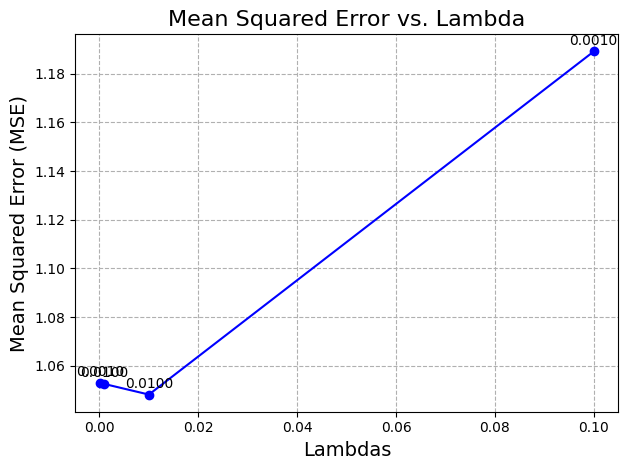

In [3]:
def plain_GD_with_momentum_OLS(X_train, X_val, y_train, y_val, degree, lmbda, momentum=0.9):
    np.random.seed(32)
    best_model = None
    best_eta = None
    min_mse_val = float('inf')
    
    # Generate polynomial features for each degree
    poly = PolynomialFeatures(degree=degree)

    # Transform the original training and validation sets
    X_train_poly = poly.fit_transform(X_train)
    X_val_poly = poly.transform(X_val)
    
    # Compute the Hessian matrix (based on X_train_poly)
    H = (2.0 / len(y_train)) * X_train_poly.T @ X_train_poly + 2 * lmbda * np.eye(X_train_poly.shape[1])
    # Get the eigenvalues
    EigValues, _ = np.linalg.eig(H)
    
    # Learning rates to test
    learning_rates = [0.001, 0.01, 0.1, 1.0 / np.max(EigValues)]
    epochs = 1000

    for eta in learning_rates:
        
        # Initialize beta with the correct size based on the degree
        beta = np.random.randn(X_train_poly.shape[1], 1)
        change = np.zeros_like(beta)  # Initialize change for momentum
        
        for iter in range(epochs):
            # Gradient of the cost function
            gradient = (2.0 / len(y_train)) * X_train_poly.T @ (X_train_poly @ beta - y_train) + 2 * lmbda * beta

            tolerance = np.full_like(gradient, 0.0001)
            
            if np.all(np.abs(gradient) <= tolerance):
                break
            # Update beta using momentum
            new_change = eta * gradient + momentum * change
            beta = beta - new_change
            change = new_change
        
        # TRAIN - Calculate MSE for training data
        y_hat_train = np.dot(X_train_poly, beta)
        mse_train = mean_squared_error(y_train, y_hat_train)
    
        # VALIDATION - Calculate MSE for validation data
        y_hat_val = np.dot(X_val_poly, beta)
        mse_val = mean_squared_error(y_val, y_hat_val)
    
        # Save the best model based on validation MSE
        if mse_val < min_mse_val:
            min_mse_val = mse_val
            best_model = beta
            best_eta = eta

    print(f"The best model having {lmbda} used eta = {best_eta} with validation MSE = {round(min_mse_val, 4)}.")
    return best_model, min_mse_val, best_eta


lambdas = [0.0001, 0.001, 0.01, 0.1]
all_mse = []
all_eta = []
for lmbda in lambdas:
    coefs, mse, eta = plain_GD_with_momentum_OLS(X_train, X_val, y_train, y_val, degree, lmbda, momentum)
    all_mse.append(mse)
    all_eta.append(eta)

print(f"Overall, the best model has lambda = {lambdas[all_mse.index(min(all_mse))]}, eta = {all_eta[all_mse.index(min(all_mse))]}, validation MSE = {min(all_mse)} and betas = {coefs}.")

plt.plot(lambdas, all_mse, marker='o', linestyle='-', color='b')
for i, txt in enumerate(all_eta):
    plt.annotate(f'{txt:.4f}', (lambdas[i], all_mse[i]), textcoords="offset points", xytext=(0,5), ha='center')

plt.xlabel("Lambdas", fontsize=14)
plt.ylabel("Mean Squared Error (MSE)", fontsize=14)
plt.title("Mean Squared Error vs. Lambda", fontsize=16)
plt.grid(True, which="both", linestyle='--')

plt.tight_layout()
plt.show()

# lmbda = 0.001
# best_model = plain_GD_with_momentum_OLS(X_train, X_val, y_train, y_val, 2, lmbda, momentum=0.9)
# best_model

### Adagrad

The best model having 0.0001 used eta = 0.1 with validation MSE = 1.0683.
The best model having 0.001 used eta = 0.1 with validation MSE = 1.0686.
The best model having 0.01 used eta = 0.1 with validation MSE = 1.0728.
The best model having 0.1 used eta = 0.1 with validation MSE = 1.1946.
Overall, the best model has lambda = 0.0001, eta = 0.1, validation MSE = 1.0682579449085505 and betas = [[3.39385315]
 [3.40175741]
 [1.84129843]].


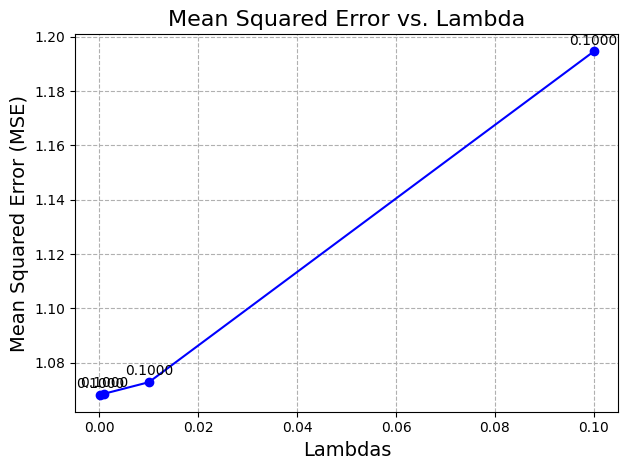

In [4]:
# Adagrad
def plain_Adagrad(X_train, X_val, y_train, y_val, degree, lmbda):
    best_model = None
    best_eta = None
    min_mse_val = float('inf')
    np.random.seed(32)
    
    # Generate polynomial features for each degree
    poly = PolynomialFeatures(degree=degree)

    # Transform the original training and validation sets
    X_train_poly = poly.fit_transform(X_train)
    X_val_poly = poly.transform(X_val)
    
    # Compute the Hessian matrix (based on X_train_poly)
    H = (2.0 / len(y_train)) * X_train_poly.T @ X_train_poly + 2 * lmbda * np.eye(X_train_poly.shape[1])
    # Get the eigenvalues
    EigValues, _ = np.linalg.eig(H)
    
    # Learning rates to test
    learning_rates = [0.001, 0.01, 0.1, 1.0 / np.max(EigValues)]
    epochs = 1000

    for eta in learning_rates:
        # Initialize beta with the correct size based on the degree
        beta = np.random.randn(X_train_poly.shape[1], 1)
        
        # Initialize accumulated squared gradients
        accumulated_gradients = np.zeros_like(beta)

        for iter in range(epochs):
            # Gradient of the cost function
            gradient = (2.0 / len(y_train)) * X_train_poly.T @ (X_train_poly @ beta - y_train) + 2 * lmbda * beta

            tolerance = np.full_like(gradient, 0.0001)
            
            if np.all(np.abs(gradient) <= tolerance):
                break
            # Accumulate squared gradients
            accumulated_gradients += gradient ** 2
            
            # Compute adjusted learning rate
            adjusted_eta = eta / (np.sqrt(accumulated_gradients) + 1e-8)  # Add small value to prevent division by zero
            
            # Update beta
            beta -= adjusted_eta * gradient
        
        # TRAIN - Calculate MSE for training data
        y_hat_train = np.dot(X_train_poly, beta)
        mse_train = mean_squared_error(y_train, y_hat_train)
    
        # VALIDATION - Calculate MSE for validation data
        y_hat_val = np.dot(X_val_poly, beta)
        mse_val = mean_squared_error(y_val, y_hat_val)
    
        # Save the best model based on validation MSE
        if mse_val < min_mse_val:
            min_mse_val = mse_val
            best_model = beta
            best_eta = eta

    print(f"The best model having {lmbda} used eta = {best_eta} with validation MSE = {round(min_mse_val, 4)}.")
    return best_model, min_mse_val, best_eta


lambdas = [0.0001, 0.001, 0.01, 0.1]
all_mse = []
all_eta = []
for lmbda in lambdas:
    coefs, mse, eta = plain_Adagrad(X_train, X_val, y_train, y_val, degree, lmbda)
    all_mse.append(mse)
    all_eta.append(eta)

print(f"Overall, the best model has lambda = {lambdas[all_mse.index(min(all_mse))]}, eta = {all_eta[all_mse.index(min(all_mse))]}, validation MSE = {min(all_mse)} and betas = {coefs}.")

plt.plot(lambdas, all_mse, marker='o', linestyle='-', color='b')
for i, txt in enumerate(all_eta):
    plt.annotate(f'{txt:.4f}', (lambdas[i], all_mse[i]), textcoords="offset points", xytext=(0,5), ha='center')

plt.xlabel("Lambdas", fontsize=14)
plt.ylabel("Mean Squared Error (MSE)", fontsize=14)
plt.title("Mean Squared Error vs. Lambda", fontsize=16)
plt.grid(True, which="both", linestyle='--')

plt.tight_layout()
plt.show()

# np.random.seed(32)
# lmbda = 0.0001
# best_model = plain_Adagrad(X_train, X_val, y_train, y_val, 2, lmbda)
# print("Best model coefficients:", best_model)

The best model having 0.0001 used eta = 0.1082724299380285 with validation MSE = 1.0339.
MSE for lambda = 0.0001: 1.0339, eta = 0.1083
The best model having 0.001 used eta = 0.1082513327953061 with validation MSE = 1.0343.
MSE for lambda = 0.001: 1.0343, eta = 0.1083
The best model having 0.01 used eta = 0.1080408126798661 with validation MSE = 1.0395.
MSE for lambda = 0.01: 1.0395, eta = 0.1080
The best model having 0.1 used eta = 0.1 with validation MSE = 1.1893.
MSE for lambda = 0.1: 1.1893, eta = 0.1000
Overall, the best model has lambda = 0.0001, eta = 0.1082724299380285, validation MSE = 1.0338840375632268 and betas = [[3.63934689]
 [2.5475523 ]
 [2.27868738]].


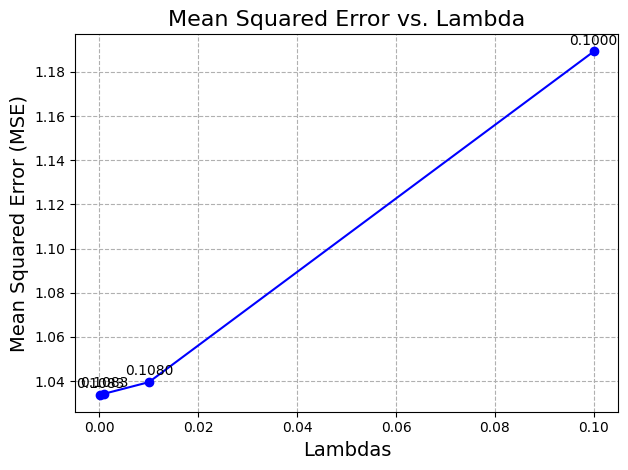

In [5]:
# Adagrad con momentum
def plain_Adagrad_momentum(X_train, X_val, y_train, y_val, degree, lmbda, momentum=0.9):
    
    np.random.seed(32)
    best_model = None
    best_eta = None
    min_mse_val = float('inf')
    
    # Generate polynomial features for each degree
    poly = PolynomialFeatures(degree=degree)

    # Transform the original training and validation sets
    X_train_poly = poly.fit_transform(X_train)
    X_val_poly = poly.transform(X_val)
    
    # Compute the Hessian matrix (based on X_train_poly)
    H = (2.0 / len(y_train)) * X_train_poly.T @ X_train_poly + 2 * lmbda * np.eye(X_train_poly.shape[1])
    # Get the eigenvalues
    EigValues, _ = np.linalg.eig(H)
    
    # Learning rates to test
    learning_rates = [0.001, 0.01, 0.1, 1.0 / np.max(EigValues)]
    epochs = 1000

    for eta in learning_rates:
        # Initialize beta with the correct size based on the degree
        beta = np.random.randn(X_train_poly.shape[1], 1)
        change = np.zeros_like(beta)
        
        # Initialize accumulated squared gradients
        accumulated_gradients = np.zeros_like(beta)

        for iter in range(epochs):
            # Gradient of the cost function
            gradient = (2.0 / len(y_train)) * X_train_poly.T @ (X_train_poly @ beta - y_train) + 2 * lmbda * beta

            tolerance = np.full_like(gradient, 0.0001)
            
            if np.all(np.abs(gradient) <= tolerance):
                break
                
            # Accumulate squared gradients
            accumulated_gradients += gradient ** 2
            
            # Compute adjusted learning rate
            adjusted_eta = eta / (np.sqrt(accumulated_gradients) + 1e-8)  # Add small value to prevent division by zero
            
            # Update beta using momentum
            new_change = adjusted_eta * gradient + momentum * change
            beta = beta - new_change
            change = new_change
        
        # TRAIN - Calculate MSE for training data
        y_hat_train = np.dot(X_train_poly, beta)
        mse_train = mean_squared_error(y_train, y_hat_train)
    
        # VALIDATION - Calculate MSE for validation data
        y_hat_val = np.dot(X_val_poly, beta)
        mse_val = mean_squared_error(y_val, y_hat_val)
    
        # Save the best model based on validation MSE
        if mse_val < min_mse_val:
            min_mse_val = mse_val
            best_model = beta
            best_eta = eta

    print(f"The best model having {lmbda} used eta = {best_eta} with validation MSE = {round(min_mse_val, 4)}.")
    return best_model, min_mse_val, best_eta

lambdas = [0.0001, 0.001, 0.01, 0.1]
all_mse = []
all_eta = []

for lmbda in lambdas:
    coefs, mse, eta = plain_Adagrad_momentum(X_train, X_val, y_train, y_val, degree, lmbda,momentum)
    all_mse.append(mse)
    all_eta.append(eta)
    print(f"MSE for lambda = {lmbda}: {mse:.4f}, eta = {eta:.4f}")  # Print MSE for each lambda

# Determine the best overall model
best_index = all_mse.index(min(all_mse))
print(f"Overall, the best model has lambda = {lambdas[best_index]}, eta = {all_eta[best_index]}, validation MSE = {min(all_mse)} and betas = {coefs}.")

# Plotting results
plt.plot(lambdas, all_mse, marker='o', linestyle='-', color='b')
for i, txt in enumerate(all_eta):
    plt.annotate(f'{txt:.4f}', (lambdas[i], all_mse[i]), textcoords="offset points", xytext=(0,5), ha='center')

plt.xlabel("Lambdas", fontsize=14)
plt.ylabel("Mean Squared Error (MSE)", fontsize=14)
plt.title("Mean Squared Error vs. Lambda", fontsize=16)
plt.grid(True, which="both", linestyle='--')
plt.tight_layout()
plt.show()


# lmbda = 0.001
# best_model = plain_Adagrad_momentum(X_train, X_val, y_train, y_val, 2, lmbda)
# print("Best model coefficients:", best_model)

### RMSprop

The best model having lambda = 0.0001 used eta = 0.1 with validation MSE = 1.0489.
The best model having lambda = 0.001 used eta = 0.01 with validation MSE = 1.0486.
The best model having lambda = 0.01 used eta = 0.1 with validation MSE = 1.0327.
The best model having lambda = 0.1 used eta = 0.01 with validation MSE = 1.2037.
Overall, the best model has lambda = 0.01, eta = 0.1, validation MSE = 1.0327173225286634 and betas = [[3.63521764]
 [2.53999706]
 [2.27491929]].


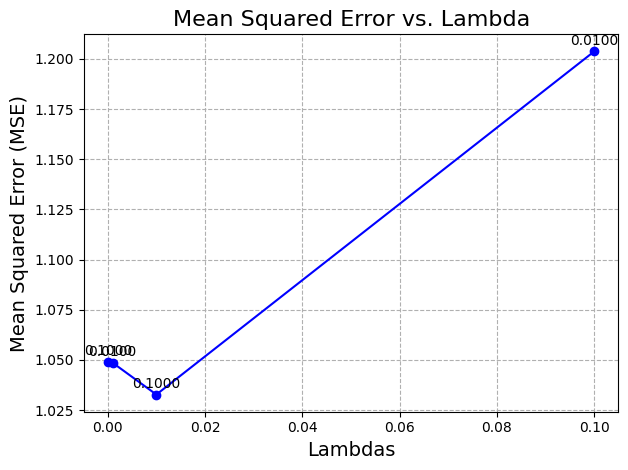

In [6]:
def plain_RMSprop(X_train, X_val, y_train, y_val, degree, lmbda, decay_rate=0.9, epsilon=1e-8):
    np.random.seed(32)
    
    best_model = None
    best_eta = None
    min_mse_val = float('inf')
    
    # Generate polynomial features for each degree
    poly = PolynomialFeatures(degree=degree)

    # Transform the original training and validation sets
    X_train_poly = poly.fit_transform(X_train)
    X_val_poly = poly.transform(X_val)
    
    # Compute the Hessian matrix (based on X_train_poly)
    H = (2.0 / len(y_train)) * X_train_poly.T @ X_train_poly + 2 * lmbda * np.eye(X_train_poly.shape[1])
    # Get the eigenvalues
    EigValues, _ = np.linalg.eig(H)
    
    # Learning rates to test
    learning_rates = [0.001, 0.01, 0.1, 1.0 / np.max(EigValues)]
    epochs = 1000

    for eta in learning_rates:
        # Initialize beta with the correct size based on the degree
        beta = np.random.randn(X_train_poly.shape[1], 1)
        
        # Initialize accumulated squared gradients for RMSprop
        accumulated_gradients = np.zeros_like(beta)
        
        for iter in range(epochs):
            # Gradient of the cost function
            gradient = (2.0 / len(y_train)) * X_train_poly.T @ (X_train_poly @ beta - y_train) + 2 * lmbda * beta

            tolerance = np.full_like(gradient, 0.0001)
            
            if np.all(np.abs(gradient) <= tolerance):
                break
                
            # Update the accumulated gradients with exponential decay
            accumulated_gradients = decay_rate * accumulated_gradients + (1 - decay_rate) * (gradient ** 2)
            
            # Compute adjusted learning rate using the accumulated gradients
            adjusted_eta = eta / (np.sqrt(accumulated_gradients) + epsilon)
            
            # Update beta using RMSprop rule
            beta -= adjusted_eta * gradient
        
        # TRAIN - Calculate MSE for training data
        y_hat_train = np.dot(X_train_poly, beta)
        mse_train = mean_squared_error(y_train, y_hat_train)
    
        # VALIDATION - Calculate MSE for validation data
        y_hat_val = np.dot(X_val_poly, beta)
        mse_val = mean_squared_error(y_val, y_hat_val)
    
        # Save the best model based on validation MSE
        if mse_val < min_mse_val:
            min_mse_val = mse_val
            best_model = beta
            best_eta = eta

    print(f"The best model having lambda = {lmbda} used eta = {best_eta} with validation MSE = {round(min_mse_val, 4)}.")
    return best_model, min_mse_val, best_eta

lambdas = [0.0001, 0.001, 0.01, 0.1]
all_mse = []
all_eta = []
for lmbda in lambdas:
    coefs, mse, eta = plain_RMSprop(X_train, X_val, y_train, y_val, degree, lmbda, decay_rate, epsilon)
    all_mse.append(mse)
    all_eta.append(eta)

print(f"Overall, the best model has lambda = {lambdas[all_mse.index(min(all_mse))]}, eta = {all_eta[all_mse.index(min(all_mse))]}, validation MSE = {min(all_mse)} and betas = {coefs}.")

plt.plot(lambdas, all_mse, marker='o', linestyle='-', color='b')
for i, txt in enumerate(all_eta):
    plt.annotate(f'{txt:.4f}', (lambdas[i], all_mse[i]), textcoords="offset points", xytext=(0,5), ha='center')

plt.xlabel("Lambdas", fontsize=14)
plt.ylabel("Mean Squared Error (MSE)", fontsize=14)
plt.title("Mean Squared Error vs. Lambda", fontsize=16)
plt.grid(True, which="both", linestyle='--')

plt.tight_layout()
plt.show()

# lmbda = 0.001
# plain_RMSprop(X_train, X_val, y_train, y_val, 2, lmbda)

The best model having lambda = 0.0001 used eta = 0.01 with validation MSE = 1.0542.
The best model having lambda = 0.001 used eta = 0.01 with validation MSE = 1.0529.
The best model having lambda = 0.01 used eta = 0.001 with validation MSE = 1.0482.
The best model having lambda = 0.1 used eta = 0.10597978706194014 with validation MSE = 1.142.
Overall, the best model has lambda = 0.01, eta = 0.001, validation MSE = 1.0481874575093566 and betas = [[3.65927357]
 [2.564053  ]
 [2.29897522]].


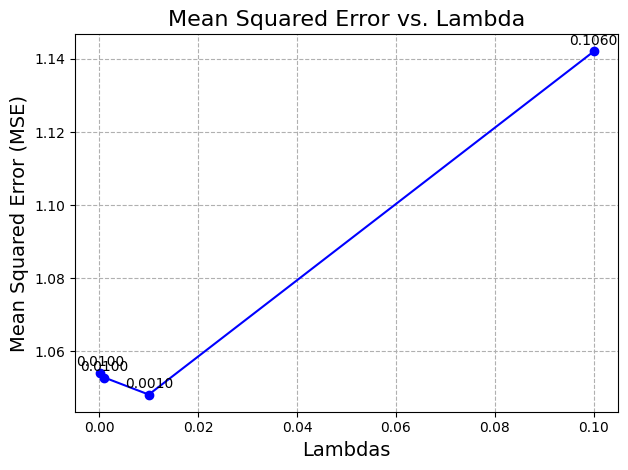

In [7]:
# momentum
def plain_RMSprop_momentum(X_train, X_val, y_train, y_val, degree, lmbda, decay_rate=0.9, epsilon=1e-8, momentum=0.9):

    np.random.seed(32)
    best_model = None
    best_eta = None
    min_mse_val = float('inf')
    
    # Generate polynomial features for each degree
    poly = PolynomialFeatures(degree=degree)

    # Transform the original training and validation sets
    X_train_poly = poly.fit_transform(X_train)
    X_val_poly = poly.transform(X_val)
    
    # Compute the Hessian matrix (based on X_train_poly)
    H = (2.0 / len(y_train)) * X_train_poly.T @ X_train_poly + 2 * lmbda * np.eye(X_train_poly.shape[1])
    # Get the eigenvalues
    EigValues, _ = np.linalg.eig(H)
    
    # Learning rates to test
    learning_rates = [0.001, 0.01, 0.1, 1.0 / np.max(EigValues)]
    epochs = 1000

    for eta in learning_rates:
        
        # Initialize beta with the correct size based on the degree
        beta = np.random.randn(X_train_poly.shape[1], 1)
        change = np.zeros_like(beta)
        
        # Initialize accumulated squared gradients for RMSprop
        accumulated_gradients = np.zeros_like(beta)
        
        for iter in range(epochs):
            # Gradient of the cost function
            gradient = (2.0 / len(y_train)) * X_train_poly.T @ (X_train_poly @ beta - y_train) + 2 * lmbda * beta

            tolerance = np.full_like(gradient, 0.0001)
            
            if np.all(np.abs(gradient) <= tolerance):
                break
                
            # Update the accumulated gradients with exponential decay
            accumulated_gradients = decay_rate * accumulated_gradients + (1 - decay_rate) * (gradient ** 2)
            
            # Compute adjusted learning rate using the accumulated gradients
            adjusted_eta = eta / (np.sqrt(accumulated_gradients) + epsilon)
            
            # Update beta using momentum
            new_change = adjusted_eta * gradient + momentum * change
            beta = beta - new_change
            change = new_change
        
        # TRAIN - Calculate MSE for training data
        y_hat_train = np.dot(X_train_poly, beta)
        mse_train = mean_squared_error(y_train, y_hat_train)
    
        # VALIDATION - Calculate MSE for validation data
        y_hat_val = np.dot(X_val_poly, beta)
        mse_val = mean_squared_error(y_val, y_hat_val)
    
        # Save the best model based on validation MSE
        if mse_val < min_mse_val:
            min_mse_val = mse_val
            best_model = beta
            best_eta = eta

    print(f"The best model having lambda = {lmbda} used eta = {best_eta} with validation MSE = {round(min_mse_val, 4)}.")
    return best_model, min_mse_val, best_eta

lambdas = [0.0001, 0.001, 0.01, 0.1]
all_mse = []
all_eta = []
for lmbda in lambdas:
    coefs, mse, eta = plain_RMSprop_momentum(X_train, X_val, y_train, y_val, degree, lmbda, decay_rate, epsilon, momentum)
    all_mse.append(mse)
    all_eta.append(eta)

print(f"Overall, the best model has lambda = {lambdas[all_mse.index(min(all_mse))]}, eta = {all_eta[all_mse.index(min(all_mse))]}, validation MSE = {min(all_mse)} and betas = {coefs}.")

plt.plot(lambdas, all_mse, marker='o', linestyle='-', color='b')
for i, txt in enumerate(all_eta):
    plt.annotate(f'{txt:.4f}', (lambdas[i], all_mse[i]), textcoords="offset points", xytext=(0,5), ha='center')

plt.xlabel("Lambdas", fontsize=14)
plt.ylabel("Mean Squared Error (MSE)", fontsize=14)
plt.title("Mean Squared Error vs. Lambda", fontsize=16)
plt.grid(True, which="both", linestyle='--')

plt.tight_layout()
plt.show()

# lmbda = 0.001
# plain_RMSprop_momentum(X_train, X_val, y_train, y_val, 2, lmbda)

### ADAM

The best model having lambda = 0.0001 used eta = 0.1082724299380285 with validation MSE = 1.0438.
The best model having lambda = 0.001 used eta = 0.1082513327953061 with validation MSE = 1.0439.
The best model having lambda = 0.01 used eta = 0.1080408126798661 with validation MSE = 1.0459.
The best model having lambda = 0.1 used eta = 0.1 with validation MSE = 1.1893.
Overall, the best model has lambda = 0.0001, eta = 0.1082724299380285, validation MSE = 1.043764537388078 and betas = [[3.64006121]
 [2.54545743]
 [2.27969693]].


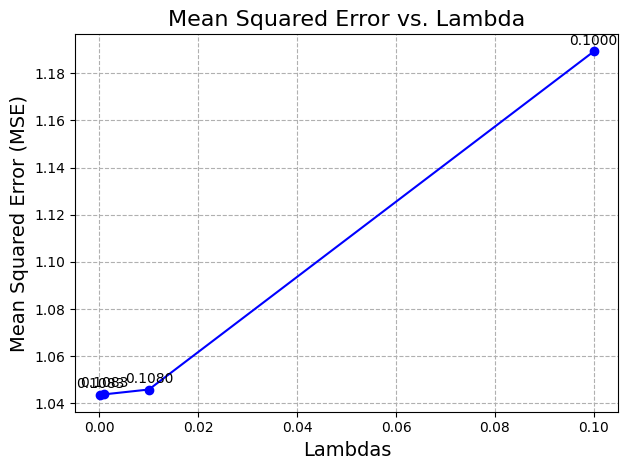

In [8]:
# Adam implementation with decay rates for moment estimates
def plain_Adam(X_train, X_val, y_train, y_val, degree, lmbda, decay1=0.9, decay2=0.999, epsilon=1e-8):

    np.random.seed(32)
    best_model = None
    best_eta = None
    min_mse_val = float('inf')
    
    # Generate polynomial features for each degree
    poly = PolynomialFeatures(degree=degree)

    # Transform the original training and validation sets
    X_train_poly = poly.fit_transform(X_train)
    X_val_poly = poly.transform(X_val)
    
    # Compute the Hessian matrix (based on X_train_poly)
    H = (2.0 / len(y_train)) * X_train_poly.T @ X_train_poly + 2 * lmbda * np.eye(X_train_poly.shape[1])
    # Get the eigenvalues
    EigValues, _ = np.linalg.eig(H)
    
    # Learning rates to test
    learning_rates = [0.001, 0.01, 0.1, 1.0 / np.max(EigValues)]
    epochs = 1000

    for eta in learning_rates:
        
        # Initialize beta with the correct size based on the degree
        beta = np.random.randn(X_train_poly.shape[1], 1)
        
        # Initialize first moment vector and second moment vector
        first_moment = np.zeros_like(beta)  # First moment (mean of gradients)
        second_moment = np.zeros_like(beta)  # Second moment (mean of squared gradients)
        time_step = 0  # Time step

        for iter in range(epochs):
            time_step += 1  # Increment the time step
            
            # Gradient of the cost function
            gradient = (2.0 / len(y_train)) * X_train_poly.T @ (X_train_poly @ beta - y_train) + 2 * lmbda * beta

            tolerance = np.full_like(gradient, 0.0001)
            
            if np.all(np.abs(gradient) <= tolerance):
                break
                
            # Update biased first moment estimate
            first_moment = decay1 * first_moment + (1 - decay1) * gradient
            
            # Update biased second raw moment estimate
            second_moment = decay2 * second_moment + (1 - decay2) * (gradient ** 2)
            
            # Correct bias in first moment
            first_moment_corrected = first_moment / (1 - decay1 ** time_step)
            # Correct bias in second moment
            second_moment_corrected = second_moment / (1 - decay2 ** time_step)

            # Update beta
            beta -= eta * first_moment_corrected / (np.sqrt(second_moment_corrected) + epsilon)
        
        # TRAIN - Calculate MSE for training data
        y_hat_train = np.dot(X_train_poly, beta)
        mse_train = mean_squared_error(y_train, y_hat_train)
    
        # VALIDATION - Calculate MSE for validation data
        y_hat_val = np.dot(X_val_poly, beta)
        mse_val = mean_squared_error(y_val, y_hat_val)
    
        # Save the best model based on validation MSE
        if mse_val < min_mse_val:
            min_mse_val = mse_val
            best_model = beta
            best_eta = eta

    print(f"The best model having lambda = {lmbda} used eta = {best_eta} with validation MSE = {round(min_mse_val, 4)}.")
    return best_model, min_mse_val, best_eta

lambdas = [0.0001, 0.001, 0.01, 0.1]
all_mse = []
all_eta = []
for lmbda in lambdas:
    coefs, mse, eta = plain_Adam(X_train, X_val, y_train, y_val, degree, lmbda, decay1, decay2, epsilon)
    all_mse.append(mse)
    all_eta.append(eta)

print(f"Overall, the best model has lambda = {lambdas[all_mse.index(min(all_mse))]}, eta = {all_eta[all_mse.index(min(all_mse))]}, validation MSE = {min(all_mse)} and betas = {coefs}.")

plt.plot(lambdas, all_mse, marker='o', linestyle='-', color='b')
for i, txt in enumerate(all_eta):
    plt.annotate(f'{txt:.4f}', (lambdas[i], all_mse[i]), textcoords="offset points", xytext=(0,5), ha='center')

plt.xlabel("Lambdas", fontsize=14)
plt.ylabel("Mean Squared Error (MSE)", fontsize=14)
plt.title("Mean Squared Error vs. Lambda", fontsize=16)
plt.grid(True, which="both", linestyle='--')

plt.tight_layout()
plt.show()

# lmbda = 0.001
# plain_Adam(X_train, X_val, y_train, y_val, 2, lmbda)

## SGD 

The best model used eta = 0.001 with validation MSE = 1.0528.
Best Model Coefficients: [[3.9069656 ]
 [3.21333108]
 [1.84599614]]
The best model having lambda = 0.0001 used eta = 0.001 with validation MSE = 1.0528.
The best model used eta = 0.001 with validation MSE = 1.0517.
Best Model Coefficients: [[3.91350512]
 [3.18123978]
 [1.86227309]]
The best model having lambda = 0.001 used eta = 0.001 with validation MSE = 1.0517.
The best model used eta = 0.001 with validation MSE = 1.0474.
Best Model Coefficients: [[3.94247799]
 [2.95947952]
 [1.97914339]]
The best model having lambda = 0.01 used eta = 0.001 with validation MSE = 1.0474.
The best model used eta = 0.001 with validation MSE = 1.1878.
Best Model Coefficients: [[3.64050617]
 [2.54543473]
 [2.28066173]]
The best model having lambda = 0.1 used eta = 0.001 with validation MSE = 1.1878.
Overall, the best model has lambda = 0.01, eta = 0.001, validation MSE = 1.0473537335677259 and betas = [[3.64050617]
 [2.54543473]
 [2.28066173]]

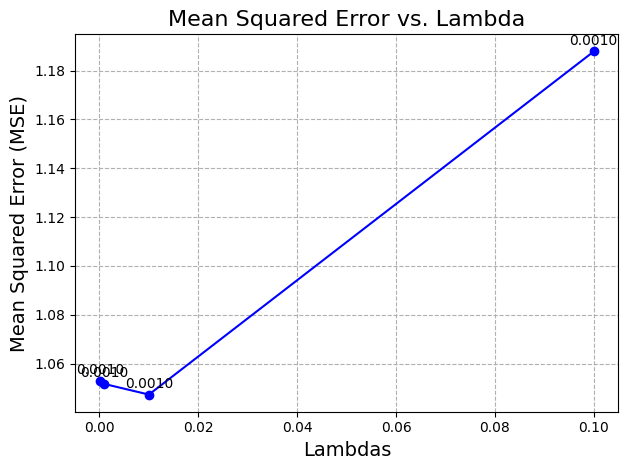

array([[3.64050617],
       [2.54543473],
       [2.28066173]])

In [9]:
# by hand SGD 
def plain_SGD_hand(X_train, X_val, y_train, y_val, degree, epochs=1000, lmbda=0.0001):
    np.random.seed(32)
    
    best_model = None
    best_eta = None
    min_mse_val = float('inf')
    
    # Generate polynomial features for each degree
    poly = PolynomialFeatures(degree=degree)

    # Transform the original training and validation sets
    X_train_poly = poly.fit_transform(X_train)
    X_val_poly = poly.transform(X_val)

    # Compute the Hessian matrix (based on X_train_poly)
    H = (2.0 / len(y_train)) * X_train_poly.T @ X_train_poly + 2 * lmbda * np.eye(X_train_poly.shape[1])
    # Get the eigenvalues
    EigValues, _ = np.linalg.eig(H)
    
    # Learning rates to test
    learning_rates = [0.001, 0.01, 0.1, 1.0 / np.max(EigValues)]
    for eta in learning_rates:
        # Initialize beta with the correct size based on the degree
        beta = np.random.randn(X_train_poly.shape[1], 1)

        for epoch in range(epochs):
            # Shuffle the training data
            indices = np.random.permutation(len(y_train))
            X_train_poly_shuffled = X_train_poly[indices]
            y_train_shuffled = y_train[indices]

            # Iterate through each training example (SGD)
            for x_i, y_i in zip(X_train_poly_shuffled, y_train_shuffled):
                x_i = x_i.reshape(-1, 1) 

                # Calculate the gradient for the single example
                gradient = 2.0 * x_i @ (x_i.T @ beta - y_i) + 2 * lmbda * beta

                # Define a small tolerance for stopping condition
                tolerance = np.full_like(gradient, 0.0001)

                # Check if the gradient is small enough to stop early
                if np.all(np.abs(gradient) <= tolerance):
                    break

                # Update beta
                beta -= eta * gradient

        # TRAIN - Calculate MSE for training data
        y_hat_train = np.dot(X_train_poly, beta)
        mse_train = mean_squared_error(y_train, y_hat_train)
    
        # VALIDATION - Calculate MSE for validation data
        y_hat_val = np.dot(X_val_poly, beta)
        mse_val = mean_squared_error(y_val, y_hat_val)

        # Save the best model based on validation MSE
        if mse_val < min_mse_val:
            min_mse_val = mse_val
            best_model = beta
            best_eta = eta

    print(f"The best model used eta = {best_eta} with validation MSE = {round(min_mse_val, 4)}.")
    print("Best Model Coefficients:", best_model)
    print(f"The best model having lambda = {lmbda} used eta = {best_eta} with validation MSE = {round(min_mse_val, 4)}.")
    return best_model, min_mse_val, best_eta

lambdas = [0.0001, 0.001, 0.01, 0.1]
all_mse = []
all_eta = []
for lmbda in lambdas:
    coefs, mse, eta = plain_SGD_hand(X_train, X_val, y_train, y_val, degree, epochs, lmbda)
    all_mse.append(mse)
    all_eta.append(eta)

print(f"Overall, the best model has lambda = {lambdas[all_mse.index(min(all_mse))]}, eta = {all_eta[all_mse.index(min(all_mse))]}, validation MSE = {min(all_mse)} and betas = {coefs}.")

plt.plot(lambdas, all_mse, marker='o', linestyle='-', color='b')
for i, txt in enumerate(all_eta):
    plt.annotate(f'{txt:.4f}', (lambdas[i], all_mse[i]), textcoords="offset points", xytext=(0,5), ha='center')

plt.xlabel("Lambdas", fontsize=14)
plt.ylabel("Mean Squared Error (MSE)", fontsize=14)
plt.title("Mean Squared Error vs. Lambda", fontsize=16)
plt.grid(True, which="both", linestyle='--')

plt.tight_layout()
plt.show()
coefs

The best model having lambda = 0.0001 used eta = 0.01 with validation MSE = 1.0303.
The best model having lambda = 0.001 used eta = 0.01 with validation MSE = 1.0303.
The best model having lambda = 0.01 used eta = 0.01 with validation MSE = 1.0327.
The best model having lambda = 0.1 used eta = 0.001 with validation MSE = 1.2039.
Overall, the best model has lambda = 0.0001, eta = 0.01, validation MSE = 1.0302533630859891 and betas = [3.61081665 2.49846129 2.3228717 ].


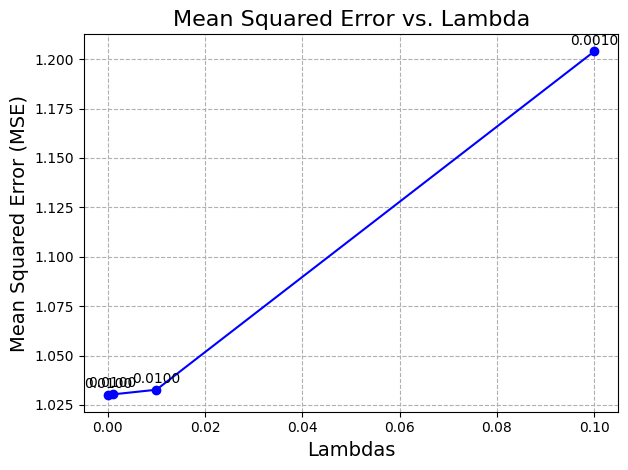

In [10]:
# Scikit learn true SGD 
def plain_SGD(X_train, X_val, y_train, y_val, degree, lmbda):
    best_model_coefficients = None
    best_eta = None
    min_mse_val = float('inf')
    np.random.seed(32)
    
    # Generate polynomial features for each degree
    poly = PolynomialFeatures(degree=degree)

    # Transform the original training and validation sets
    X_train_poly = poly.fit_transform(X_train) 
    X_val_poly = poly.transform(X_val)
    
    # Compute the Hessian matrix (based on X_train_poly)
    H = (2.0 / len(y_train)) * X_train_poly.T @ X_train_poly + 2 * lmbda * np.eye(X_train_poly.shape[1])
    # Get the eigenvalues
    EigValues, _ = np.linalg.eig(H)
    
    # Learning rates to test
    learning_rates = [0.001, 0.01, 0.1, 1.0 / np.max(EigValues)]
    epochs = 1000

    for eta in learning_rates:
        # Create the SGDRegressor model 
        sgdreg = SGDRegressor(max_iter=epochs, penalty='l2', alpha=lmbda, eta0=eta, learning_rate='constant', fit_intercept=False)
        sgdreg.fit(X_train_poly, y_train.ravel())
        
        # TRAIN - Calculate MSE for training data
        y_hat_train = sgdreg.predict(X_train_poly)
        mse_train = mean_squared_error(y_train, y_hat_train)
    
        # VALIDATION - Calculate MSE for validation data
        y_hat_val = sgdreg.predict(X_val_poly)
        mse_val = mean_squared_error(y_val, y_hat_val)
    
        # Save the best model coefficients based on validation MSE
        if mse_val < min_mse_val:
            min_mse_val = mse_val
            # Concatenate intercept and coefficients into a single array
            best_model_coefficients = sgdreg.coef_
            best_eta = eta

    #print(f"Model coefficients: {best_model_coefficients}")
    print(f"The best model having lambda = {lmbda} used eta = {best_eta} with validation MSE = {round(min_mse_val, 4)}.")
    return best_model_coefficients, min_mse_val, best_eta

lambdas = [0.0001, 0.001, 0.01, 0.1]
all_mse = []
all_eta = []
for lmbda in lambdas:
    coefs, mse, eta = plain_SGD(X_train, X_val, y_train, y_val, degree, lmbda)
    all_mse.append(mse)
    all_eta.append(eta)

print(f"Overall, the best model has lambda = {lambdas[all_mse.index(min(all_mse))]}, eta = {all_eta[all_mse.index(min(all_mse))]}, validation MSE = {min(all_mse)} and betas = {coefs}.")

plt.plot(lambdas, all_mse, marker='o', linestyle='-', color='b')
for i, txt in enumerate(all_eta):
    plt.annotate(f'{txt:.4f}', (lambdas[i], all_mse[i]), textcoords="offset points", xytext=(0,5), ha='center')

plt.xlabel("Lambdas", fontsize=14)
plt.ylabel("Mean Squared Error (MSE)", fontsize=14)
plt.title("Mean Squared Error vs. Lambda", fontsize=16)
plt.grid(True, which="both", linestyle='--')

plt.tight_layout()
plt.show()

# lmbda = 0.001
# plain_SGD(X_train, X_val, y_train, y_val, 2, lmbda)

## MGD

The best model having lambda = 0.0001 used eta = 0.1082724299380285 with validation MSE = 1.0393.
The best model having lambda = 0.001 used eta = 0.1082513327953061 with validation MSE = 1.0375.
The best model having lambda = 0.01 used eta = 0.1080408126798661 with validation MSE = 1.0284.
The best model having lambda = 0.1 used eta = 0.10597978706194014 with validation MSE = 1.138.
Overall, the best model has lambda = 0.01, eta = 0.1080408126798661, validation MSE = 1.028367373396867 and betas = [[3.65553588]
 [2.56322345]
 [2.3076657 ]].


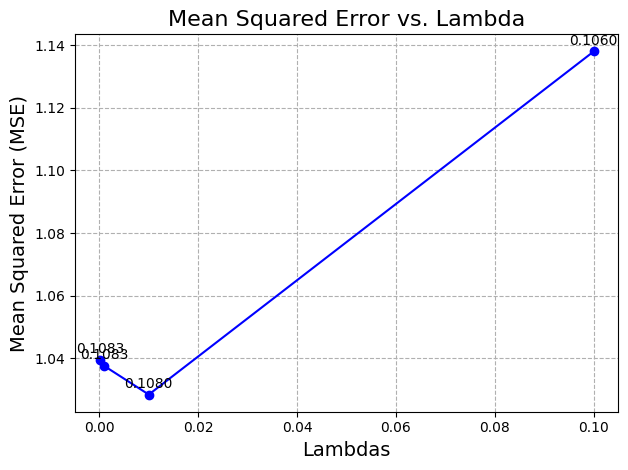

In [11]:
# by hand
def plain_SGD_with_mini_batches(X_train, X_val, y_train, y_val, degree, lmbda, batch_size=32, epochs=1000):
    best_model = None
    best_eta = None
    min_mse_val = float('inf')

    np.random.seed(32)
    # Generate polynomial features for each degree
    poly = PolynomialFeatures(degree=degree)

    # Transform the original training and validation sets
    X_train_poly = poly.fit_transform(X_train)
    X_val_poly = poly.transform(X_val)

    # Compute the Hessian matrix (based on X_train_poly)
    H = (2.0 / len(y_train)) * X_train_poly.T @ X_train_poly + 2 * lmbda * np.eye(X_train_poly.shape[1])
    # Get the eigenvalues
    EigValues, _ = np.linalg.eig(H)
    
    # Learning rates to test
    learning_rates = [0.001, 0.01, 0.1, 1.0 / np.max(EigValues)]
    for eta in learning_rates:
        # Initialize beta with the correct size based on the degree
        beta = np.random.randn(X_train_poly.shape[1], 1)

        for epoch in range(epochs):
            # Shuffle the training data
            indices = np.random.permutation(len(y_train))
            X_train_poly_shuffled = X_train_poly[indices]
            y_train_shuffled = y_train[indices]

            for i in range(0, len(y_train), batch_size):
                # Create mini-batch
                X_batch = X_train_poly_shuffled[i:i + batch_size]
                y_batch = y_train_shuffled[i:i + batch_size]

                # Calculate the gradient for the mini-batch
                gradient = (2.0 / len(y_batch)) * X_batch.T @ (X_batch @ beta - y_batch) + 2 * lmbda * beta

                tolerance = np.full_like(gradient, 0.0001)
            
                if np.all(np.abs(gradient) <= tolerance):
                    break
                    
                # Update beta
                beta -= eta * gradient

        # TRAIN - Calculate MSE for training data
        y_hat_train = np.dot(X_train_poly, beta)
        mse_train = mean_squared_error(y_train, y_hat_train)
    
        # VALIDATION - Calculate MSE for validation data
        y_hat_val = np.dot(X_val_poly, beta)
        mse_val = mean_squared_error(y_val, y_hat_val)

        # Save the best model based on validation MSE
        if mse_val < min_mse_val:
            min_mse_val = mse_val
            best_model = beta
            best_eta = eta

    print(f"The best model having lambda = {lmbda} used eta = {best_eta} with validation MSE = {round(min_mse_val, 4)}.")
    return best_model, min_mse_val, best_eta

lambdas = [0.0001, 0.001, 0.01, 0.1]
all_mse = []
all_eta = []
for lmbda in lambdas:
    coefs, mse, eta = plain_SGD_with_mini_batches(X_train, X_val, y_train, y_val, degree, lmbda, batch_size, epochs)
    all_mse.append(mse)
    all_eta.append(eta)

print(f"Overall, the best model has lambda = {lambdas[all_mse.index(min(all_mse))]}, eta = {all_eta[all_mse.index(min(all_mse))]}, validation MSE = {min(all_mse)} and betas = {coefs}.")

plt.plot(lambdas, all_mse, marker='o', linestyle='-', color='b')
for i, txt in enumerate(all_eta):
    plt.annotate(f'{txt:.4f}', (lambdas[i], all_mse[i]), textcoords="offset points", xytext=(0,5), ha='center')

plt.xlabel("Lambdas", fontsize=14)
plt.ylabel("Mean Squared Error (MSE)", fontsize=14)
plt.title("Mean Squared Error vs. Lambda", fontsize=16)
plt.grid(True, which="both", linestyle='--')

plt.tight_layout()
plt.show()


# lmbda = 0.001
# best_model = plain_SGD_with_mini_batches(X_train, X_val, y_train, y_val, 2, lmbda)
# print("Best Model Coefficients:", best_model)

### momentum

The best model having lambda = 0.0001 used eta = 0.1 with validation MSE = 1.0383.
The best model having lambda = 0.001 used eta = 0.1 with validation MSE = 1.0365.
The best model having lambda = 0.01 used eta = 0.1 with validation MSE = 1.0275.
The best model having lambda = 0.1 used eta = 0.10597978706194014 with validation MSE = 1.0822.
Overall, the best model has lambda = 0.01, eta = 0.1, validation MSE = 1.0274946604237871 and betas = [[3.71763431]
 [2.6278969 ]
 [2.38358678]]..


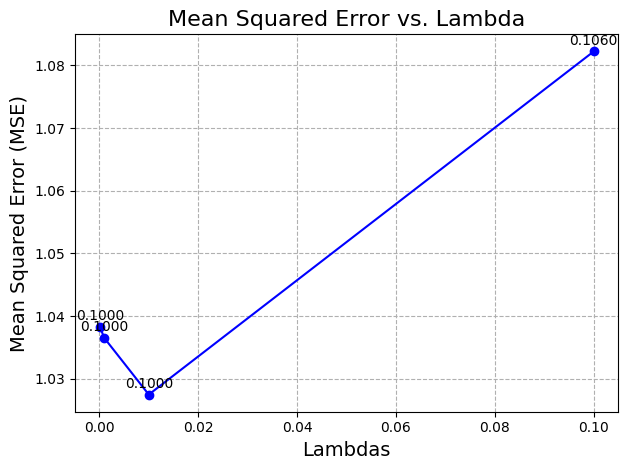

In [12]:
# SGD batch with momentum
def plain_SGD_with_momentum_Ridge(X_train, X_val, y_train, y_val, degree, lmbda, momentum=0.9, batch_size=32, epochs=1000):
    best_model = None
    best_eta = None
    min_mse_val = float('inf')
    np.random.seed(32)
    
    # Generate polynomial features for each degree
    poly = PolynomialFeatures(degree=degree)

    # Transform the original training and validation sets
    X_train_poly = poly.fit_transform(X_train)
    X_val_poly = poly.transform(X_val)
    
    # Compute the Hessian matrix (based on X_train_poly)
    H = (2.0 / len(y_train)) * X_train_poly.T @ X_train_poly + 2 * lmbda * np.eye(X_train_poly.shape[1])
    # Get the eigenvalues
    EigValues, _ = np.linalg.eig(H)
    
    # Learning rates to test
    learning_rates = [0.001, 0.01, 0.1, 1.0 / np.max(EigValues)]

    for eta in learning_rates:
        
        # Initialize beta with the correct size based on the degree
        beta = np.random.randn(X_train_poly.shape[1], 1)

        change = np.zeros_like(beta)  # Initialize change for momentum
        
        for epoch in range(epochs):
            # Shuffle the training data
            indices = np.random.permutation(len(y_train))
            X_train_poly_shuffled = X_train_poly[indices]
            y_train_shuffled = y_train[indices]

            for i in range(0, len(y_train), batch_size):
                # Create mini-batch
                X_batch = X_train_poly_shuffled[i:i + batch_size]
                y_batch = y_train_shuffled[i:i + batch_size]

                # Calculate the gradient for the mini-batch
                gradient = (2.0 / len(y_batch)) * X_batch.T @ (X_batch @ beta - y_batch) + 2 * lmbda * beta

                tolerance = np.full_like(gradient, 0.0001)
            
                if np.all(np.abs(gradient) <= tolerance):
                    break
                # Update beta using momentum
                new_change = eta * gradient + momentum * change
                beta = beta - new_change
                change = new_change
                
        # TRAIN - Calculate MSE for training data
        y_hat_train = np.dot(X_train_poly, beta)
        mse_train = mean_squared_error(y_train, y_hat_train)
    
        # VALIDATION - Calculate MSE for validation data
        y_hat_val = np.dot(X_val_poly, beta)
        mse_val = mean_squared_error(y_val, y_hat_val)
    
        # Save the best model based on validation MSE
        if mse_val < min_mse_val:
            min_mse_val = mse_val
            best_model = beta
            best_eta = eta

    #print(f"Model coefficients: {best_model_coefficients}")
    print(f"The best model having lambda = {lmbda} used eta = {best_eta} with validation MSE = {round(min_mse_val, 4)}.")
    return best_model, min_mse_val, best_eta

lambdas = [0.0001, 0.001, 0.01, 0.1]
all_mse = []
all_eta = []
for lmbda in lambdas:
    coefs, mse, eta = plain_SGD_with_momentum_Ridge(X_train, X_val, y_train, y_val, degree, lmbda, momentum, batch_size, epochs)
    all_mse.append(mse)
    all_eta.append(eta)

print(f"Overall, the best model has lambda = {lambdas[all_mse.index(min(all_mse))]}, eta = {all_eta[all_mse.index(min(all_mse))]}, validation MSE = {min(all_mse)} and betas = {coefs}..")

plt.plot(lambdas, all_mse, marker='o', linestyle='-', color='b')
for i, txt in enumerate(all_eta):
    plt.annotate(f'{txt:.4f}', (lambdas[i], all_mse[i]), textcoords="offset points", xytext=(0,5), ha='center')

plt.xlabel("Lambdas", fontsize=14)
plt.ylabel("Mean Squared Error (MSE)", fontsize=14)
plt.title("Mean Squared Error vs. Lambda", fontsize=16)
plt.grid(True, which="both", linestyle='--')

plt.tight_layout()
plt.show()

# lmbda = 0.001
# best_model = plain_SGD_with_momentum_Ridge(X_train, X_val, y_train, y_val, degree=2, lmbda = lmbda, momentum=0.9, batch_size=16, epochs=1000)
# best_model

### minibatch scikit

The best model having lambda = 0.0001 used eta = 0.001 with validation MSE = 1.0419.
The best model having lambda = 0.001 used eta = 0.1 with validation MSE = 1.0413.
The best model having lambda = 0.01 used eta = 0.1 with validation MSE = 1.0323.
The best model having lambda = 0.1 used eta = 0.1 with validation MSE = 1.1234.
Overall, the best model has lambda = 0.01, eta = 0.1, validation MSE = 1.0323208763917284 and betas = [3.67094764 2.47320131 2.38958064].


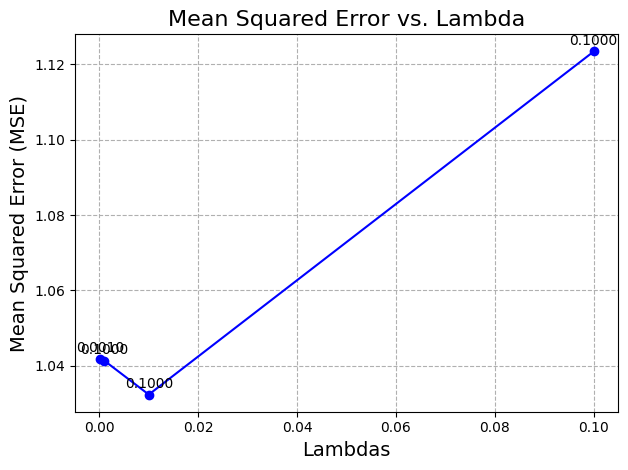

In [13]:
# Scikit learn minibatch 
def plain_SGD_with_batches(X_train, X_val, y_train, y_val, degree, lmbda, batch_size=32, epochs=1000):
    np.random.seed(32)
    best_model_coefficients = None
    best_eta = None
    min_mse_val = float('inf')
    
    # Generate polynomial features for each degree
    poly = PolynomialFeatures(degree=degree)

    # Transform the original training and validation sets
    X_train_poly = poly.fit_transform(X_train) 
    X_val_poly = poly.transform(X_val)
    
    # Compute the Hessian matrix (based on X_train_poly)
    H = (2.0 / len(y_train)) * X_train_poly.T @ X_train_poly + 2 * lmbda * np.eye(X_train_poly.shape[1])
    # Get the eigenvalues
    EigValues, _ = np.linalg.eig(H)
    
    # Learning rates to test
    learning_rates = [0.001, 0.01, 0.1, 1.0 / np.max(EigValues)]

    for eta in learning_rates:
        # Initialize SGDRegressor with the specified learning rate
        sgdreg = SGDRegressor(max_iter=1, penalty='l2', alpha=lmbda, eta0=eta, learning_rate='constant', fit_intercept=False)
        
        for epoch in range(epochs):
            # Shuffle the training data
            indices = np.random.permutation(len(y_train))
            X_train_poly_shuffled = X_train_poly[indices]
            y_train_shuffled = y_train[indices]

            # Iterate over mini-batches
            for i in range(0, len(y_train), batch_size):
                # Create mini-batch
                X_batch = X_train_poly_shuffled[i:i + batch_size]
                y_batch = y_train_shuffled[i:i + batch_size]
                
                # Fit the model on the mini-batch
                sgdreg.partial_fit(X_batch, y_batch.ravel())

        # TRAIN - Calculate MSE for training data
        y_hat_train = sgdreg.predict(X_train_poly)
        mse_train = mean_squared_error(y_train, y_hat_train)
    
        # VALIDATION - Calculate MSE for validation data
        y_hat_val = sgdreg.predict(X_val_poly)
        mse_val = mean_squared_error(y_val, y_hat_val)
    
        # Save the best model coefficients based on validation MSE
        if mse_val < min_mse_val:
            min_mse_val = mse_val
            best_model_coefficients = sgdreg.coef_
            best_eta = eta

    #print(f"Model coefficients: {best_model_coefficients}")
    print(f"The best model having lambda = {lmbda} used eta = {best_eta} with validation MSE = {round(min_mse_val, 4)}.")
    return best_model_coefficients, min_mse_val, best_eta

lambdas = [0.0001, 0.001, 0.01, 0.1]
all_mse = []
all_eta = []
for lmbda in lambdas:
    coefs, mse, eta =  plain_SGD_with_batches(X_train, X_val, y_train, y_val, degree, lmbda, batch_size, epochs)
    all_mse.append(mse)
    all_eta.append(eta)

print(f"Overall, the best model has lambda = {lambdas[all_mse.index(min(all_mse))]}, eta = {all_eta[all_mse.index(min(all_mse))]}, validation MSE = {min(all_mse)} and betas = {coefs}.")

plt.plot(lambdas, all_mse, marker='o', linestyle='-', color='b')
for i, txt in enumerate(all_eta):
    plt.annotate(f'{txt:.4f}', (lambdas[i], all_mse[i]), textcoords="offset points", xytext=(0,5), ha='center')

plt.xlabel("Lambdas", fontsize=14)
plt.ylabel("Mean Squared Error (MSE)", fontsize=14)
plt.title("Mean Squared Error vs. Lambda", fontsize=16)
plt.grid(True, which="both", linestyle='--')

plt.tight_layout()
plt.show()

# lmbda = 0.001
# best_model_coefficients = plain_SGD_with_batches(X_train, X_val, y_train, y_val, degree=2, lmbda=lmbda, batch_size=32, epochs=1000)


### Adagrad

The best model having lambda = 0.0001 used eta = 0.1 with validation MSE = 1.0432.
The best model having lambda = 0.001 used eta = 0.1 with validation MSE = 1.0433.
The best model having lambda = 0.01 used eta = 0.1 with validation MSE = 1.046.
The best model having lambda = 0.1 used eta = 0.1 with validation MSE = 1.1899.
Overall, the best model has lambda = 0.0001, eta = 0.1, validation MSE = 1.0431747045102857 and betas = [[3.61988408]
 [2.59464078]
 [2.2576147 ]].


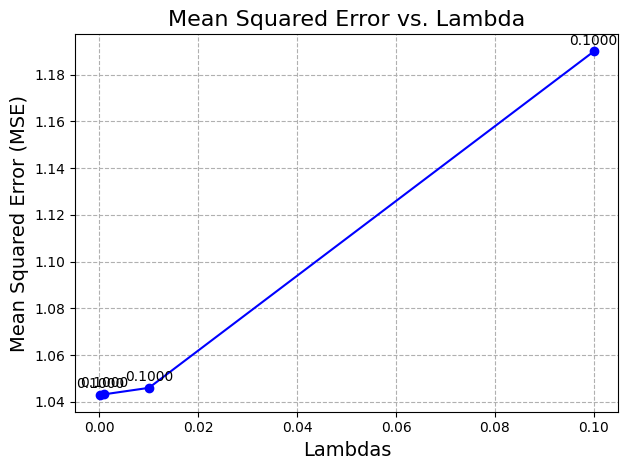

In [14]:
# Adagrad no memntum
def SGD_Adagrad(X_train, X_val, y_train, y_val, degree, lmbda, batch_size=32, epochs=1000):
    np.random.seed(32)
    best_model = None
    best_eta = None
    min_mse_val = float('inf')
    
    # Generate polynomial features for each degree
    poly = PolynomialFeatures(degree=degree)

    # Transform the original training and validation sets
    X_train_poly = poly.fit_transform(X_train)
    X_val_poly = poly.transform(X_val)
    
    # Compute the Hessian matrix (based on X_train_poly)
    H = (2.0 / len(y_train)) * X_train_poly.T @ X_train_poly + 2 * lmbda * np.eye(X_train_poly.shape[1])
    # Get the eigenvalues
    EigValues, _ = np.linalg.eig(H)
    
    # Learning rates to test
    learning_rates = [0.001, 0.01, 0.1, 1.0 / np.max(EigValues)]

    for eta in learning_rates:
        # Initialize beta with the correct size based on the degree
        beta = np.random.randn(X_train_poly.shape[1], 1)
        
        # Initialize accumulated squared gradients
        accumulated_gradients = np.zeros_like(beta)

        for epoch in range(epochs):
            
            # Shuffle the training data
            indices = np.random.permutation(len(y_train))
            X_train_poly_shuffled = X_train_poly[indices]
            y_train_shuffled = y_train[indices]

            for i in range(0, len(y_train), batch_size):
                # Create mini-batch
                X_batch = X_train_poly_shuffled[i:i + batch_size]
                y_batch = y_train_shuffled[i:i + batch_size]

                # Calculate the gradient for the mini-batch
                gradient = (2.0 / len(y_batch)) * X_batch.T @ (X_batch @ beta - y_batch) + 2 * lmbda * beta

                tolerance = np.full_like(gradient, 0.0001)
            
                if np.all(np.abs(gradient) <= tolerance):
                    break
                    
                # Accumulate squared gradients
                accumulated_gradients += gradient ** 2
                
                # Compute adjusted learning rate
                adjusted_eta = eta / (np.sqrt(accumulated_gradients) + 1e-8)  # Add small value to prevent division by zero
                
                # Update beta
                beta -= adjusted_eta * gradient
        
        # TRAIN - Calculate MSE for training data
        y_hat_train = np.dot(X_train_poly, beta)
        mse_train = mean_squared_error(y_train, y_hat_train)
    
        # VALIDATION - Calculate MSE for validation data
        y_hat_val = np.dot(X_val_poly, beta)
        mse_val = mean_squared_error(y_val, y_hat_val)
    
        # Save the best model based on validation MSE
        if mse_val < min_mse_val:
            min_mse_val = mse_val
            best_model = beta
            best_eta = eta

    #print(f"Model coefficients: {best_model_coefficients}")
    print(f"The best model having lambda = {lmbda} used eta = {best_eta} with validation MSE = {round(min_mse_val, 4)}.")
    return best_model, min_mse_val, best_eta

lambdas = [0.0001, 0.001, 0.01, 0.1]
all_mse = []
all_eta = []
for lmbda in lambdas:
    coefs, mse, eta = SGD_Adagrad(X_train, X_val, y_train, y_val, degree, lmbda, batch_size, epochs)
    all_mse.append(mse)
    all_eta.append(eta)

print(f"Overall, the best model has lambda = {lambdas[all_mse.index(min(all_mse))]}, eta = {all_eta[all_mse.index(min(all_mse))]}, validation MSE = {min(all_mse)} and betas = {coefs}.")

plt.plot(lambdas, all_mse, marker='o', linestyle='-', color='b')
for i, txt in enumerate(all_eta):
    plt.annotate(f'{txt:.4f}', (lambdas[i], all_mse[i]), textcoords="offset points", xytext=(0,5), ha='center')

plt.xlabel("Lambdas", fontsize=14)
plt.ylabel("Mean Squared Error (MSE)", fontsize=14)
plt.title("Mean Squared Error vs. Lambda", fontsize=16)
plt.grid(True, which="both", linestyle='--')

plt.tight_layout()
plt.show()


# lmbda = 0.001
# best_model = SGD_Adagrad(X_train, X_val, y_train, y_val, 2, lmbda)
# print("Best model coefficients:", best_model)

The best model having lambda = 0.0001 used eta = 0.1 with validation MSE = 1.0531.
The best model having lambda = 0.001 used eta = 0.1 with validation MSE = 1.0522.
The best model having lambda = 0.01 used eta = 0.1 with validation MSE = 1.0487.
The best model having lambda = 0.1 used eta = 0.10597978706194014 with validation MSE = 1.1871.
Overall, the best model has lambda = 0.01, eta = 0.1, validation MSE = 1.0487282085575427 and betas = [[3.64064182]
 [2.54610307]
 [2.28074029]].


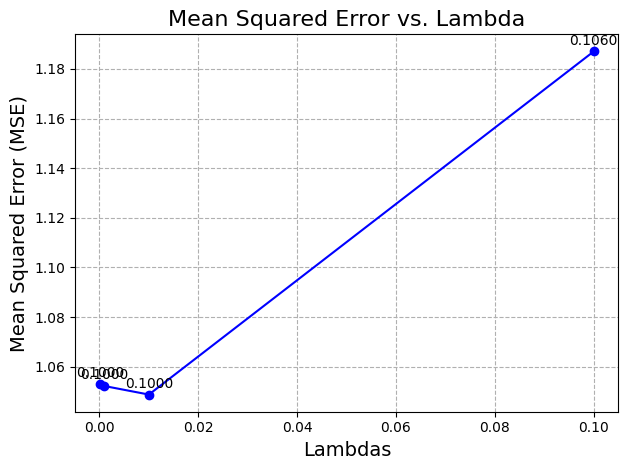

In [15]:
# Adagrad momentum 
def SGD_Adagrad_momentum(X_train, X_val, y_train, y_val, degree, lmbda, batch_size=32, epochs=1000, momentum=0.9):
    np.random.seed(32)
    best_model = None
    best_eta = None
    min_mse_val = float('inf')
    
    # Generate polynomial features for each degree
    poly = PolynomialFeatures(degree=degree)

    # Transform the original training and validation sets
    X_train_poly = poly.fit_transform(X_train)
    X_val_poly = poly.transform(X_val)
    
    # Compute the Hessian matrix (based on X_train_poly)
    H = (2.0 / len(y_train)) * X_train_poly.T @ X_train_poly + 2 * lmbda * np.eye(X_train_poly.shape[1])
    # Get the eigenvalues
    EigValues, _ = np.linalg.eig(H)
    
    # Learning rates to test
    learning_rates = [0.001, 0.01, 0.1, 1.0 / np.max(EigValues)]

    for eta in learning_rates:
        # Initialize beta with the correct size based on the degree
        beta = np.random.randn(X_train_poly.shape[1], 1)
        
        # Initialize accumulated squared gradients
        accumulated_gradients = np.zeros_like(beta)

        # Initialize change for momentum
        change = np.zeros_like(beta)  

        for epoch in range(epochs):
            
            # Shuffle the training data
            indices = np.random.permutation(len(y_train))
            X_train_poly_shuffled = X_train_poly[indices]
            y_train_shuffled = y_train[indices]

            for i in range(0, len(y_train), batch_size):
                # Create mini-batch
                X_batch = X_train_poly_shuffled[i:i + batch_size]
                y_batch = y_train_shuffled[i:i + batch_size]

                # Calculate the gradient for the mini-batch
                gradient = (2.0 / len(y_batch)) * X_batch.T @ (X_batch @ beta - y_batch) + 2 * lmbda * beta

                tolerance = np.full_like(gradient, 0.0001)
            
                if np.all(np.abs(gradient) <= tolerance):
                    break
                    
                # Accumulate squared gradients
                accumulated_gradients += gradient ** 2
                
                # Compute adjusted learning rate
                adjusted_eta = eta / (np.sqrt(accumulated_gradients) + 1e-8)  # Add small value to prevent division by zero
                
                # Update beta using momentum
                new_change = adjusted_eta * gradient + momentum * change
                beta = beta - new_change
                change = new_change
        
        # TRAIN - Calculate MSE for training data
        y_hat_train = np.dot(X_train_poly, beta)
        mse_train = mean_squared_error(y_train, y_hat_train)
    
        # VALIDATION - Calculate MSE for validation data
        y_hat_val = np.dot(X_val_poly, beta)
        mse_val = mean_squared_error(y_val, y_hat_val)
    
        # Save the best model based on validation MSE
        if mse_val < min_mse_val:
            min_mse_val = mse_val
            best_model = beta
            best_eta = eta

    #print(f"Model coefficients: {best_model_coefficients}")
    print(f"The best model having lambda = {lmbda} used eta = {best_eta} with validation MSE = {round(min_mse_val, 4)}.")
    return best_model, min_mse_val, best_eta

lambdas = [0.0001, 0.001, 0.01, 0.1]
all_mse = []
all_eta = []
for lmbda in lambdas:
    coefs, mse, eta = SGD_Adagrad_momentum(X_train, X_val, y_train, y_val, degree, lmbda, batch_size, epochs, momentum)
    all_mse.append(mse)
    all_eta.append(eta)

print(f"Overall, the best model has lambda = {lambdas[all_mse.index(min(all_mse))]}, eta = {all_eta[all_mse.index(min(all_mse))]}, validation MSE = {min(all_mse)} and betas = {coefs}.")

plt.plot(lambdas, all_mse, marker='o', linestyle='-', color='b')
for i, txt in enumerate(all_eta):
    plt.annotate(f'{txt:.4f}', (lambdas[i], all_mse[i]), textcoords="offset points", xytext=(0,5), ha='center')

plt.xlabel("Lambdas", fontsize=14)
plt.ylabel("Mean Squared Error (MSE)", fontsize=14)
plt.title("Mean Squared Error vs. Lambda", fontsize=16)
plt.grid(True, which="both", linestyle='--')

plt.tight_layout()
plt.show()

# lmbda = 0.001
# best_model = SGD_Adagrad_momentum(X_train, X_val, y_train, y_val, 2, lmbda)
# print("Best model coefficients:", best_model)

### RMSprop


The best model having lambda = 0.0001 used eta = 0.01 with validation MSE = 1.053.
The best model having lambda = 0.001 used eta = 0.01 with validation MSE = 1.0523.
The best model having lambda = 0.01 used eta = 0.01 with validation MSE = 1.0499.
The best model having lambda = 0.1 used eta = 0.10597978706194014 with validation MSE = 1.0765.
Overall, the best model has lambda = 0.01, eta = 0.01, validation MSE = 1.0498626837425942 and betas = [[3.7129022 ]
 [2.61681873]
 [2.35175045]].


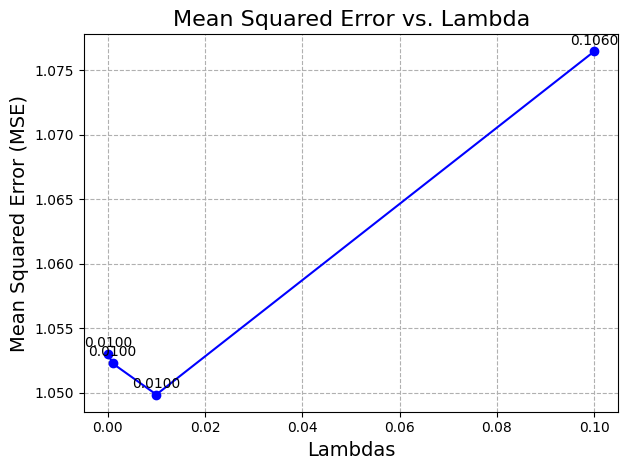

In [16]:
# no momentum
def SGD_RMSprop(X_train, X_val, y_train, y_val, degree, lmbda, batch_size=32, epochs=1000, decay_rate=0.9):
    np.random.seed(32)
    
    best_model = None
    best_eta = None
    min_mse_val = float('inf')
    
    # Generate polynomial features for each degree
    poly = PolynomialFeatures(degree=degree)

    # Transform the original training and validation sets
    X_train_poly = poly.fit_transform(X_train)
    X_val_poly = poly.transform(X_val)
    
    # Compute the Hessian matrix (based on X_train_poly)
    H = (2.0 / len(y_train)) * X_train_poly.T @ X_train_poly + 2 * lmbda * np.eye(X_train_poly.shape[1])
    # Get the eigenvalues
    EigValues, _ = np.linalg.eig(H)
    
    # Learning rates to test
    learning_rates = [0.001, 0.01, 0.1, 1.0 / np.max(EigValues)]

    for eta in learning_rates:
        # Initialize beta with the correct size based on the degree
        beta = np.random.randn(X_train_poly.shape[1], 1)
        
        # Initialize accumulated squared gradients
        accumulated_gradients = np.zeros_like(beta)

        for epoch in range(epochs):
            
            # Shuffle the training data
            indices = np.random.permutation(len(y_train))
            X_train_poly_shuffled = X_train_poly[indices]
            y_train_shuffled = y_train[indices]

            for i in range(0, len(y_train), batch_size):
                # Create mini-batch
                X_batch = X_train_poly_shuffled[i:i + batch_size]
                y_batch = y_train_shuffled[i:i + batch_size]

                # Calculate the gradient for the mini-batch
                gradient = (2.0 / len(y_batch)) * X_batch.T @ (X_batch @ beta - y_batch) + 2 * lmbda * beta

                tolerance = np.full_like(gradient, 0.0001)
            
                if np.all(np.abs(gradient) <= tolerance):
                    break
                    
                # Accumulate squared gradients
                accumulated_gradients =  decay_rate * accumulated_gradients + (1 - decay_rate) * (gradient ** 2)
                
                # Compute adjusted learning rate
                adjusted_eta = eta / (np.sqrt(accumulated_gradients) + 1e-8)  # Add small value to prevent division by zero
                
                # Update beta
                beta -= adjusted_eta * gradient
        
        # TRAIN - Calculate MSE for training data
        y_hat_train = np.dot(X_train_poly, beta)
        mse_train = mean_squared_error(y_train, y_hat_train)
    
        # VALIDATION - Calculate MSE for validation data
        y_hat_val = np.dot(X_val_poly, beta)
        mse_val = mean_squared_error(y_val, y_hat_val)
    
        # Save the best model based on validation MSE
        if mse_val < min_mse_val:
            min_mse_val = mse_val
            best_model = beta
            best_eta = eta

    #print(f"Model coefficients: {best_model_coefficients}")
    print(f"The best model having lambda = {lmbda} used eta = {best_eta} with validation MSE = {round(min_mse_val, 4)}.")
    return best_model, min_mse_val, best_eta

lambdas = [0.0001, 0.001, 0.01, 0.1]
all_mse = []
all_eta = []
for lmbda in lambdas:
    coefs, mse, eta = SGD_RMSprop(X_train, X_val, y_train, y_val, degree, lmbda, batch_size, epochs, decay_rate)
    all_mse.append(mse)
    all_eta.append(eta)

print(f"Overall, the best model has lambda = {lambdas[all_mse.index(min(all_mse))]}, eta = {all_eta[all_mse.index(min(all_mse))]}, validation MSE = {min(all_mse)} and betas = {coefs}.")

plt.plot(lambdas, all_mse, marker='o', linestyle='-', color='b')
for i, txt in enumerate(all_eta):
    plt.annotate(f'{txt:.4f}', (lambdas[i], all_mse[i]), textcoords="offset points", xytext=(0,5), ha='center')

plt.xlabel("Lambdas", fontsize=14)
plt.ylabel("Mean Squared Error (MSE)", fontsize=14)
plt.title("Mean Squared Error vs. Lambda", fontsize=16)
plt.grid(True, which="both", linestyle='--')

plt.tight_layout()
plt.show()

# lmbda = 0.001
# best_model = SGD_RMSprop(X_train, X_val, y_train, y_val, 2, lmbda)
# print("Best model coefficients:", best_model)

The best model having lambda = 0.0001 used eta = 0.01 with validation MSE = 1.0474.
The best model having lambda = 0.001 used eta = 0.01 with validation MSE = 1.046.
The best model having lambda = 0.01 used eta = 0.1 with validation MSE = 1.0326.
The best model having lambda = 0.1 used eta = 0.10597978706194014 with validation MSE = 1.0805.
Overall, the best model has lambda = 0.01, eta = 0.1, validation MSE = 1.0326148645014972 and betas = [[3.79305108]
 [2.64159491]
 [2.38165979]].


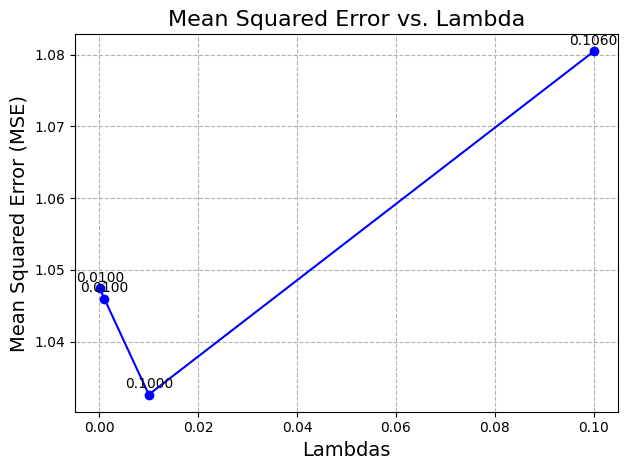

In [17]:
# momentum
def SGD_RMSprop_momentum(X_train, X_val, y_train, y_val, degree, lmbda, batch_size=32, epochs=1000, decay_rate=0.9, momentum=0.9):
    np.random.seed(32)
    
    best_model = None
    best_eta = None
    min_mse_val = float('inf')
    
    # Generate polynomial features for each degree
    poly = PolynomialFeatures(degree=degree)

    # Transform the original training and validation sets
    X_train_poly = poly.fit_transform(X_train)
    X_val_poly = poly.transform(X_val)
    
    # Compute the Hessian matrix (based on X_train_poly)
    H = (2.0 / len(y_train)) * X_train_poly.T @ X_train_poly + 2 * lmbda * np.eye(X_train_poly.shape[1])
    # Get the eigenvalues
    EigValues, _ = np.linalg.eig(H)
    
    # Learning rates to test
    learning_rates = [0.001, 0.01, 0.1, 1.0 / np.max(EigValues)]

    for eta in learning_rates:
        # Initialize beta with the correct size based on the degree
        beta = np.random.randn(X_train_poly.shape[1], 1)
        
        # Initialize accumulated squared gradients
        accumulated_gradients = np.zeros_like(beta)

        # Initialize change for momentum
        change = np.zeros_like(beta)  

        for epoch in range(epochs):
            
            # Shuffle the training data
            indices = np.random.permutation(len(y_train))
            X_train_poly_shuffled = X_train_poly[indices]
            y_train_shuffled = y_train[indices]

            for i in range(0, len(y_train), batch_size):
                # Create mini-batch
                X_batch = X_train_poly_shuffled[i:i + batch_size]
                y_batch = y_train_shuffled[i:i + batch_size]

                # Calculate the gradient for the mini-batch
                gradient = (2.0 / len(y_batch)) * X_batch.T @ (X_batch @ beta - y_batch) + 2 * lmbda * beta

                tolerance = np.full_like(gradient, 0.0001)
            
                if np.all(np.abs(gradient) <= tolerance):
                    break
                    
                # Accumulate squared gradients
                accumulated_gradients =  decay_rate * accumulated_gradients + (1 - decay_rate) * (gradient ** 2)
                
                # Compute adjusted learning rate
                adjusted_eta = eta / (np.sqrt(accumulated_gradients) + 1e-8)  # Add small value to prevent division by zero
                
                # Update beta using momentum
                new_change = adjusted_eta * gradient + momentum * change
                beta = beta - new_change
                change = new_change
                
        # TRAIN - Calculate MSE for training data
        y_hat_train = np.dot(X_train_poly, beta)
        mse_train = mean_squared_error(y_train, y_hat_train)
    
        # VALIDATION - Calculate MSE for validation data
        y_hat_val = np.dot(X_val_poly, beta)
        mse_val = mean_squared_error(y_val, y_hat_val)
    
        # Save the best model based on validation MSE
        if mse_val < min_mse_val:
            min_mse_val = mse_val
            best_model = beta
            best_eta = eta

    #print(f"Model coefficients: {best_model_coefficients}")
    print(f"The best model having lambda = {lmbda} used eta = {best_eta} with validation MSE = {round(min_mse_val, 4)}.")
    return best_model, min_mse_val, best_eta

lambdas = [0.0001, 0.001, 0.01, 0.1]
all_mse = []
all_eta = []
for lmbda in lambdas:
    coefs, mse, eta = SGD_RMSprop_momentum(X_train, X_val, y_train, y_val, degree, lmbda, batch_size, epochs, decay_rate, momentum)
    all_mse.append(mse)
    all_eta.append(eta)

print(f"Overall, the best model has lambda = {lambdas[all_mse.index(min(all_mse))]}, eta = {all_eta[all_mse.index(min(all_mse))]}, validation MSE = {min(all_mse)} and betas = {coefs}.")

plt.plot(lambdas, all_mse, marker='o', linestyle='-', color='b')
for i, txt in enumerate(all_eta):
    plt.annotate(f'{txt:.4f}', (lambdas[i], all_mse[i]), textcoords="offset points", xytext=(0,5), ha='center')

plt.xlabel("Lambdas", fontsize=14)
plt.ylabel("Mean Squared Error (MSE)", fontsize=14)
plt.title("Mean Squared Error vs. Lambda", fontsize=16)
plt.grid(True, which="both", linestyle='--')

plt.tight_layout()
plt.show()

# lmbda = 0.001
# best_model = SGD_RMSprop_momentum(X_train, X_val, y_train, y_val, 2, lmbda)
# print("Best model coefficients:", best_model)

### ADAM

The best model having lambda = 0.0001 used eta = 0.01 with validation MSE = 1.0336.
The best model having lambda = 0.001 used eta = 0.01 with validation MSE = 1.034.
The best model having lambda = 0.01 used eta = 0.01 with validation MSE = 1.0399.
The best model having lambda = 0.1 used eta = 0.1 with validation MSE = 1.1832.
Overall, the best model has lambda = 0.0001, eta = 0.01, validation MSE = 1.0335504322888653 and betas = [[3.64186375]
 [2.54606269]
 [2.28332788]].


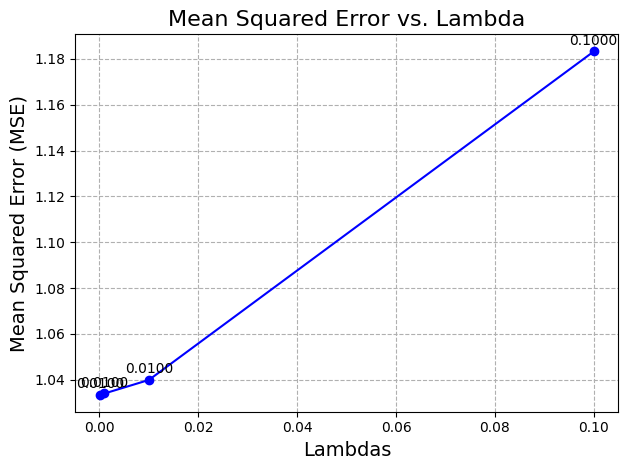

In [18]:
# by hand
def SGD_ADAM(X_train, X_val, y_train, y_val, degree, lmbda, batch_size=32, epochs=1000, decay1=0.9, decay2=0.999, epsilon=1e-8):
    np.random.seed(32)
    best_model = None
    best_eta = None
    min_mse_val = float('inf')
    
    # Generate polynomial features for each degree
    poly = PolynomialFeatures(degree=degree)
    
    # Transform the original training and validation sets
    X_train_poly = poly.fit_transform(X_train)
    X_val_poly = poly.transform(X_val)

    # Compute the Hessian matrix (based on X_train_poly)
    H = (2.0 / len(y_train)) * X_train_poly.T @ X_train_poly + 2 * lmbda * np.eye(X_train_poly.shape[1])
    # Get the eigenvalues
    EigValues, _ = np.linalg.eig(H)
    
    # Learning rates to test
    learning_rates = [0.001, 0.01, 0.1, 1.0 / np.max(EigValues)]
    
    for eta in learning_rates:
        # Initialize beta with the correct size based on the degree
        beta = np.random.randn(X_train_poly.shape[1], 1)

        # Initialize first moment vector and second moment vector
        first_moment = np.zeros_like(beta)  # First moment (mean of gradients)
        second_moment = np.zeros_like(beta)  # Second moment (mean of squared gradients)
        time_step = 0  # Time step

        for epoch in range(epochs):
            # Shuffle the training data
            indices = np.random.permutation(len(y_train))
            X_train_poly_shuffled = X_train_poly[indices]
            y_train_shuffled = y_train[indices]

            for i in range(0, len(y_train), batch_size):
                time_step += 1
                
                # Create mini-batch
                X_batch = X_train_poly_shuffled[i:i + batch_size]
                y_batch = y_train_shuffled[i:i + batch_size]

                # Calculate the gradient for the mini-batch
                gradient = (2.0 / len(y_batch)) * X_batch.T @ (X_batch @ beta - y_batch) + 2 * lmbda * beta

                tolerance = np.full_like(gradient, 0.0001)
            
                if np.all(np.abs(gradient) <= tolerance):
                    break
                    
                # Update biased first moment estimate
                first_moment = decay1 * first_moment + (1 - decay1) * gradient
                
                # Update biased second raw moment estimate
                second_moment = decay2 * second_moment + (1 - decay2) * (gradient ** 2)
                
                # Correct bias in first moment
                first_moment_corrected = first_moment / (1 - decay1 ** time_step)
                # Correct bias in second moment
                second_moment_corrected = second_moment / (1 - decay2 ** time_step)
    
                # Update beta
                beta -= eta * first_moment_corrected / (np.sqrt(second_moment_corrected) + epsilon)
            
        # TRAIN - Calculate MSE for training data
        y_hat_train = np.dot(X_train_poly, beta)
        mse_train = mean_squared_error(y_train, y_hat_train)
    
        # VALIDATION - Calculate MSE for validation data
        y_hat_val = np.dot(X_val_poly, beta)
        mse_val = mean_squared_error(y_val, y_hat_val)

        # Save the best model based on validation MSE
        if mse_val < min_mse_val:
            min_mse_val = mse_val
            best_model = beta
            best_eta = eta

    #print(f"Model coefficients: {best_model_coefficients}")
    print(f"The best model having lambda = {lmbda} used eta = {best_eta} with validation MSE = {round(min_mse_val, 4)}.")
    return best_model, min_mse_val, best_eta

lambdas = [0.0001, 0.001, 0.01, 0.1]
all_mse = []
all_eta = []
for lmbda in lambdas:
    coefs, mse, eta = SGD_ADAM(X_train, X_val, y_train, y_val, degree, lmbda, batch_size, epochs, decay1, decay2, epsilon)
    all_mse.append(mse)
    all_eta.append(eta)

print(f"Overall, the best model has lambda = {lambdas[all_mse.index(min(all_mse))]}, eta = {all_eta[all_mse.index(min(all_mse))]}, validation MSE = {min(all_mse)} and betas = {coefs}.")

plt.plot(lambdas, all_mse, marker='o', linestyle='-', color='b')
for i, txt in enumerate(all_eta):
    plt.annotate(f'{txt:.4f}', (lambdas[i], all_mse[i]), textcoords="offset points", xytext=(0,5), ha='center')

plt.xlabel("Lambdas", fontsize=14)
plt.ylabel("Mean Squared Error (MSE)", fontsize=14)
plt.title("Mean Squared Error vs. Lambda", fontsize=16)
plt.grid(True, which="both", linestyle='--')

plt.tight_layout()
plt.show()
# lmbda = 0.001
# best_model = SGD_ADAM(X_train, X_val, y_train, y_val, degree=2, lmbda=lmbda, batch_size=32, epochs=1000)
# print("Best Model Coefficients:", best_model)